# Import and data loading

In [1]:
!pip install dm-haiku optax numpyro chainconsumer
!pip install git+https://github.com/renecotyfanboy/jaxspec.git@apec#egg=jaxspec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chainconsumer: filename=ChainConsumer-0.34.0-py3-none-any.whl size=42758 sha256=dd7cae8463d1bf3c4fe069a3b183af8a90782db029859d08d5f99ed7863e4d78
  Stored in directory: /root/.cache/pip/wheels/16/c7/e4/d5a52c011267ad4523a83b033f21a17d9ebb606f688d4ec897
Successfully built chainconsumer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/renecotyfanboy/jaxspec.git (to revision apec) to /tmp/pip-install-m_dyb5b0/jaxspec_657da60a3bf5499ebc16c555ebac4177
  Running command git clone --filter=blob:none --quiet https://github

In [2]:
!mkdir data
!gdown 1i7I8QAaKg_hSkMW-Kk-VOKzCcm1zH9VB -O data --folder

Retrieving folder list
Processing file 12Z_umrUQQyEPXiSK80qYahLO89s4RcHS 1050300109.arf
Processing file 1z3IkFzbignTC82kUEOIQjOu5LEmueLMk 1050300109.rmf
Processing file 1E77XxuP3UEQ5xngQ7aVfzRLYW4Bx_hH7 duration_from_peak_0.7s_b_006_017_opt.pha
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=12Z_umrUQQyEPXiSK80qYahLO89s4RcHS
To: /content/data/1050300109.arf
100% 127k/127k [00:00<00:00, 34.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z3IkFzbignTC82kUEOIQjOu5LEmueLMk
To: /content/data/1050300109.rmf
100% 20.8M/20.8M [00:00<00:00, 88.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1E77XxuP3UEQ5xngQ7aVfzRLYW4Bx_hH7
To: /content/data/duration_from_peak_0.7s_b_006_017_opt.pha
100% 28.8k/28.8k [00:00<00:00, 64.2MB/s]
Download completed


In [3]:
import numpy as np
from jax.config import config
config.update("jax_enable_x64", True)
import numpyro

numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)

import haiku as hk
import jax.numpy as jnp

# XSPEC but in Pure Python ?! And it's differentiable 😱 🙀 😱

## Fit a 3 component model on 3 observations

In [4]:
from jaxspec.model.additive import Powerlaw, Blackbody
from jaxspec.model.multiplicative import Tbabs

In [5]:
import numpyro
import numpyro.distributions as dist
import arviz as az
from jaxspec.data.util import example_observations as obs_list
from jaxspec.fit import BayesianModel

model = Tbabs()*Powerlaw()

prior = {'powerlaw_1':
            {'alpha': dist.Uniform(0, 10),
             'norm': dist.Exponential(1e4)},
         'tbabs_1':
             {'N_H': dist.Uniform(0, 1)}
         }

forward = BayesianModel(model, list(obs_list.values()))

inference_data = forward.fit(prior, kernel_kwargs={'dense_mass':False, 'max_tree_depth':8})

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

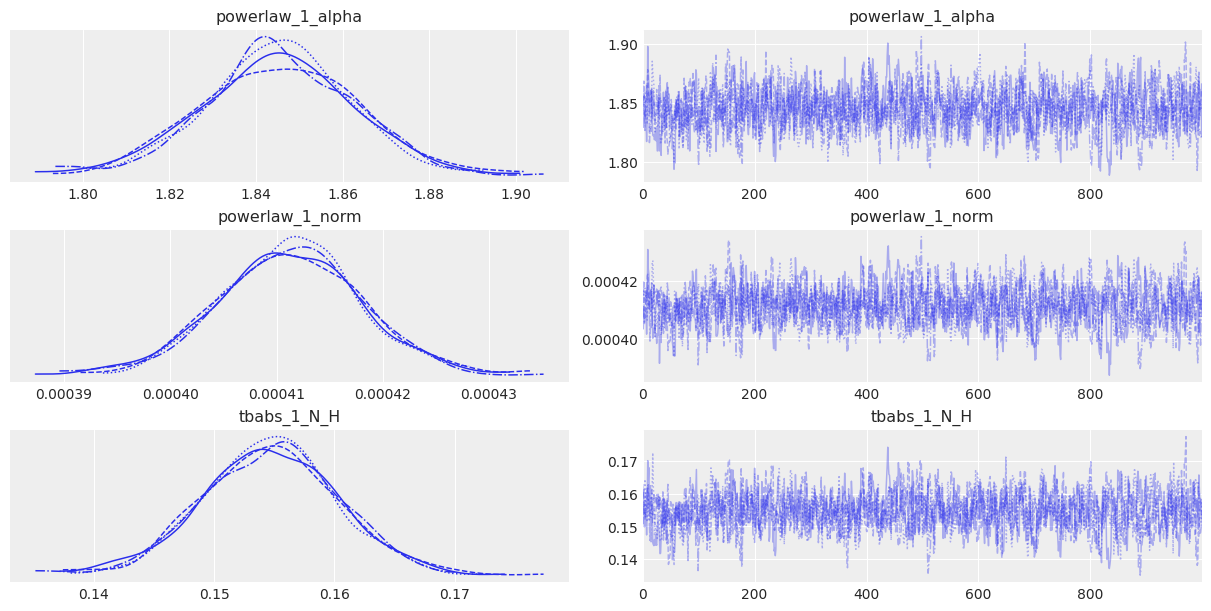

In [6]:
with az.style.context("arviz-darkgrid", after_reset=True):
    az.plot_trace(inference_data);

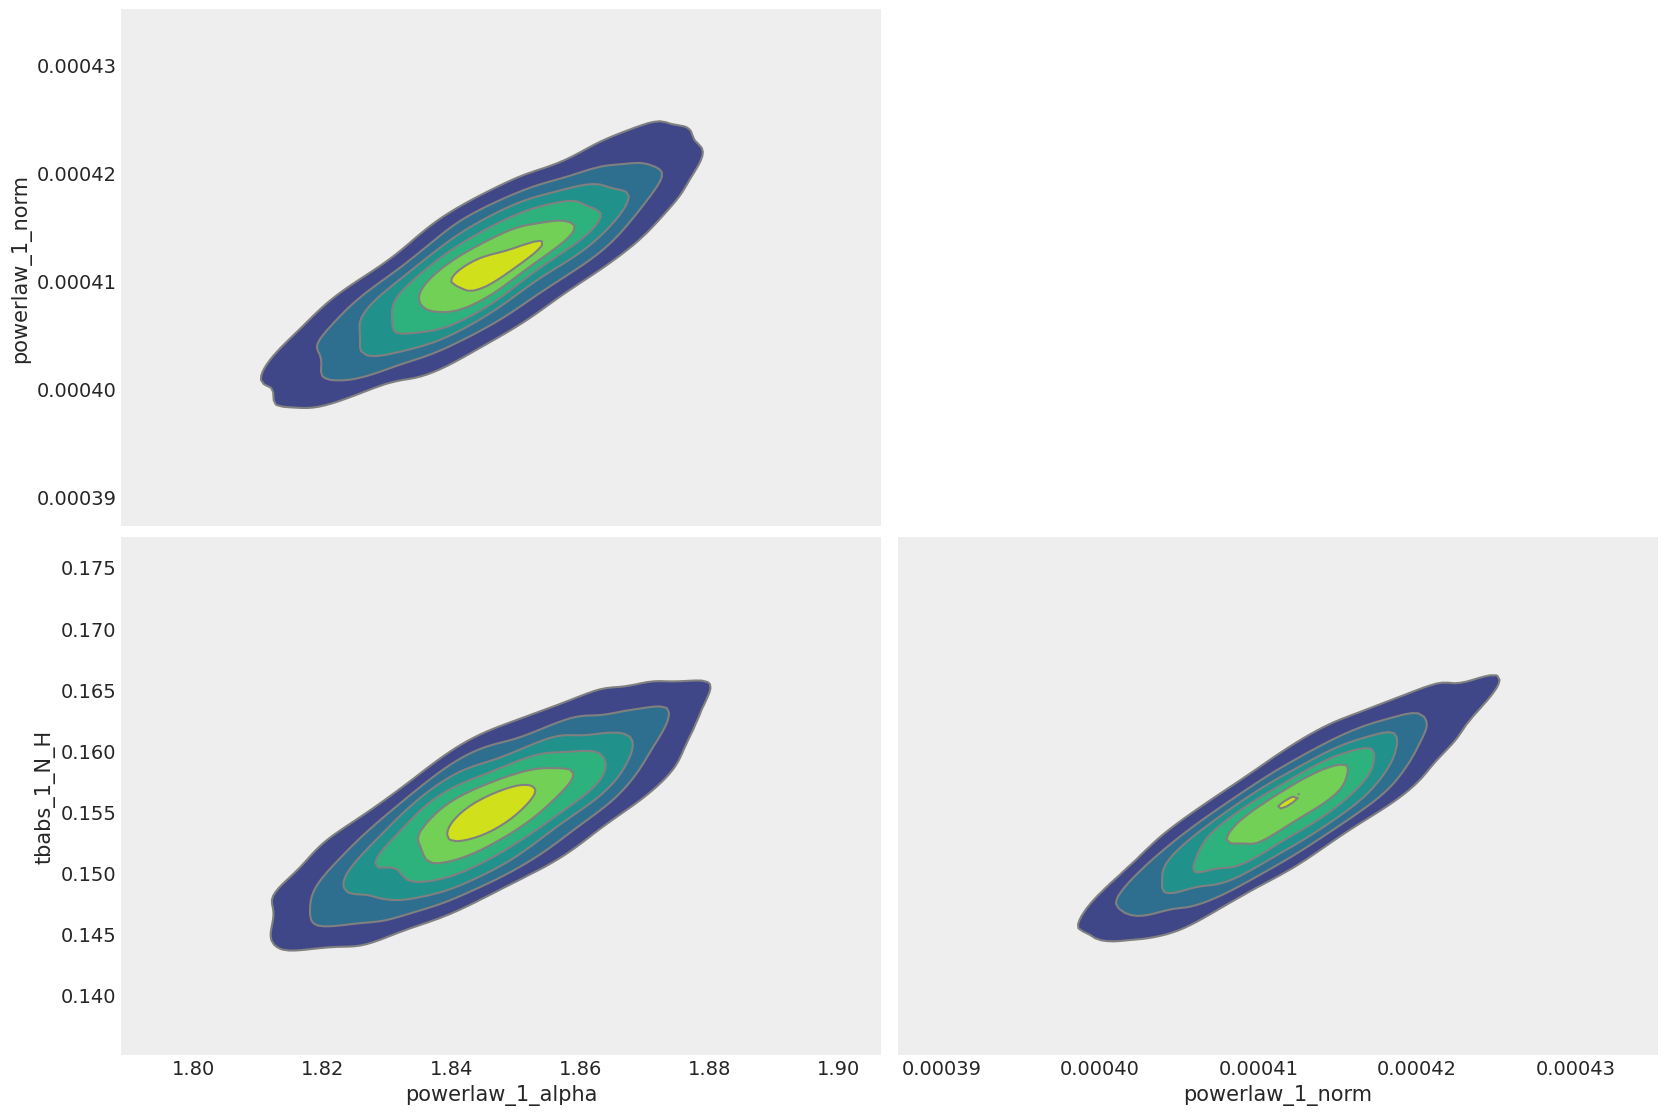

In [7]:
with az.style.context("arviz-darkgrid", after_reset=True):
    az.plot_pair(inference_data, kind='kde');

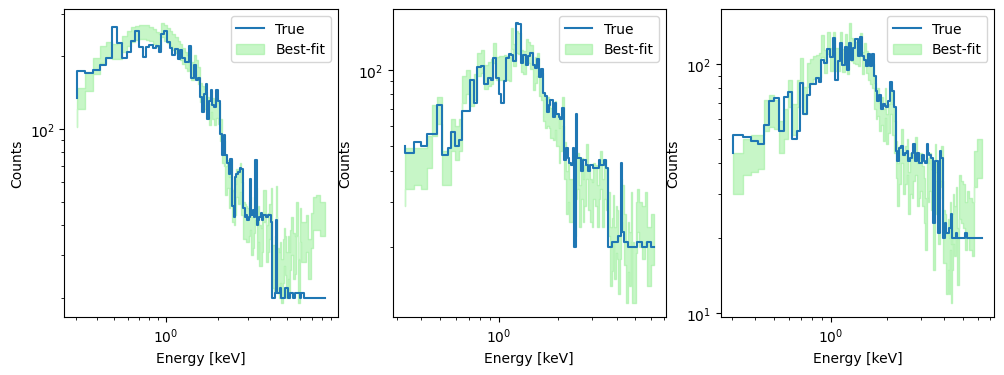

In [8]:
import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jaxspec.fit import CountForwardModel

parameters = hk.data_structures.to_haiku_dict(prior)
res = az.extract(inference_data)

for i, (m, n, to_set) in enumerate(hk.data_structures.traverse(parameters)):

    if isinstance(to_set, dist.Distribution):
        parameters[m][n] = jnp.asarray(res[f'{m}_{n}'])

    else :
        parameters[m][n] = jnp.ones((4000,))*to_set

plt.figure(figsize=(12,4))

for i in range(3):

    obs = list(obs_list.values())[i]

    transformed_model = hk.without_apply_rng(hk.transform(lambda par: CountForwardModel(model, obs)(par)))
    intru_model = jax.jit(lambda p: transformed_model.apply(None, p))
    instru_posterior = np.random.poisson(jax.vmap(intru_model)(parameters))

    plt.subplot(131+i)
    plt.step(obs.out_energies[0], obs.observed_counts, label='True', where="pre")
    plt.fill_between(obs.out_energies[0], *np.percentile(instru_posterior, [14, 86], axis=0), alpha=0.5, color='lightgreen', label='Best-fit', step="pre");
    plt.legend()
    plt.ylabel('Counts')
    plt.xlabel('Energy [keV]')
    plt.loglog();

## What if I want to use my own data ?

Load your pha in the same way you would do as in XSPEC !



In [9]:
from jaxspec.data.observation import Observation
from jaxspec.model.additive import Powerlaw, Blackbodyrad, Gauss
from jaxspec.model.multiplicative import Gabs

obs = Observation.from_pha_file('data/duration_from_peak_0.7s_b_006_017_opt.pha', low_energy=0.5,high_energy=10.)
model = Tbabs()*(Powerlaw() + Blackbodyrad())
forward = BayesianModel(model, obs)

prior = {'blackbodyrad_1':
              {'kT': dist.Uniform(0., 5.),
                'norm': dist.LogUniform(1e3, 1e5)},
          'powerlaw_1':
              {'alpha': dist.Uniform(0., 5.),
                'norm': dist.Uniform(0., 10.)},
          'tbabs_1':
              {'N_H': dist.Uniform(0., 1.)}
          }

results = {}

results['NUTS'] = forward.fit(prior,
                             kernel_kwargs={'dense_mass':False, 'max_tree_depth':8},
                             return_inference_data=False)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Once we got our parameters, we can plot the posterior predictive distribution for our spectrum and model ! It will be integrated in JAXSPEC at some point.

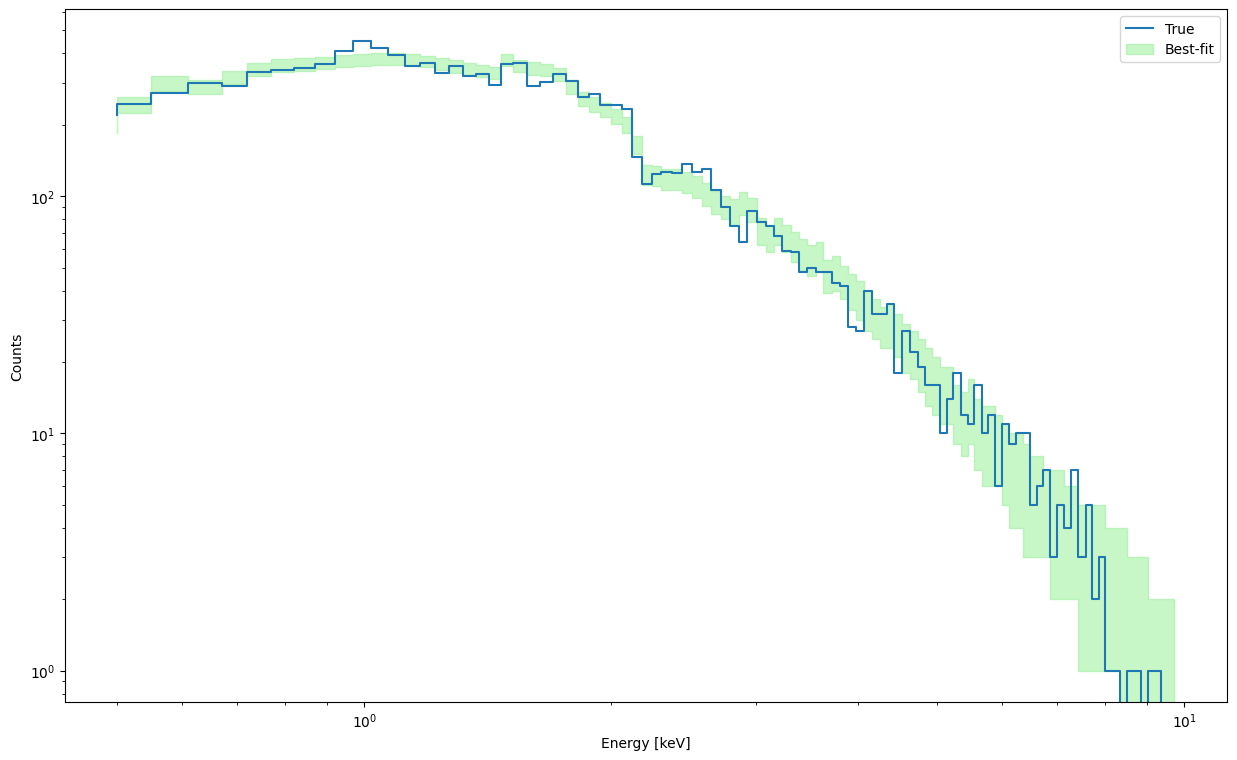

In [10]:
parameters = hk.data_structures.to_haiku_dict(prior)
res = az.extract(results['NUTS'])

for i, (m, n, to_set) in enumerate(hk.data_structures.traverse(parameters)):

    if isinstance(to_set, dist.Distribution):
        parameters[m][n] = jnp.asarray(res[f'{m}_{n}'])

    else :
        parameters[m][n] = jnp.ones((4000,))*to_set


transformed_model = hk.without_apply_rng(hk.transform(lambda par: CountForwardModel(model, obs)(par)))
intru_model = jax.jit(lambda p: transformed_model.apply(None, p))
instru_posterior = np.random.poisson(jax.vmap(intru_model)(parameters))

plt.figure(figsize=(15,9))
plt.step(obs.out_energies[0], obs.observed_counts, label='True', where="pre")
plt.fill_between(obs.out_energies[0], *np.percentile(instru_posterior, [14, 86], axis=0), alpha=0.5, color='lightgreen', label='Best-fit', step="pre");
plt.legend()
plt.ylabel('Counts')
plt.xlabel('Energy [keV]')
plt.loglog();

Since all the JAXSPEC package works over JAX and numpyro, it exposes fuzzy features such as Variational Inference interfaces that are proposed in numpyro. Variational Inference is a methodology for solving Bayesian Inference problem which is quite different from classic MCMC sampling. When sampling with MCMC, your aim is to get samples which are approximately distributed according to the underlying posterior distribution. In Variational Inference, you suppose a model for your distribution which will be adjusted to fit to the actual posterior distribution. This is achieved by minimizing the [Evidence lower bound ](https://en.wikipedia.org/wiki/Evidence_lower_bound).

In [11]:
import optax
from jax.random import PRNGKey
from numpyro.optim import optax_to_numpyro
from numpyro.infer import autoguide
from numpyro.infer import SVI, Trace_ELBO, autoguide

numpyro_model = forward.numpyro_model(prior)

guides_to_fit = {
                 'laplace_approx' : autoguide.AutoLaplaceApproximation(numpyro_model),
                 'mvnormal' : autoguide.AutoMultivariateNormal(numpyro_model),
                 'flow' : autoguide.AutoBNAFNormal(numpyro_model, hidden_factors=[8, 8]),
                 }

for key, guide in guides_to_fit.items():

    optimizer = optax_to_numpyro(optax.lion(1e-3))#numpyro.optim.Adam(step_size=5e-4)
    svi = SVI(numpyro_model, guide, optimizer, loss=Trace_ELBO())
    svi_result = svi.run(PRNGKey(0), 20000)
    params = svi_result.params
    results[key] = autoguide_samples = guide.sample_posterior(
        PRNGKey(np.random.randint(0, int(1e6))), params, sample_shape=(10000,)
    )

100%|██████████| 20000/20000 [01:00<00:00, 330.42it/s, init loss: 449890.5250, avg. loss [19001-20000]: 369.4918]


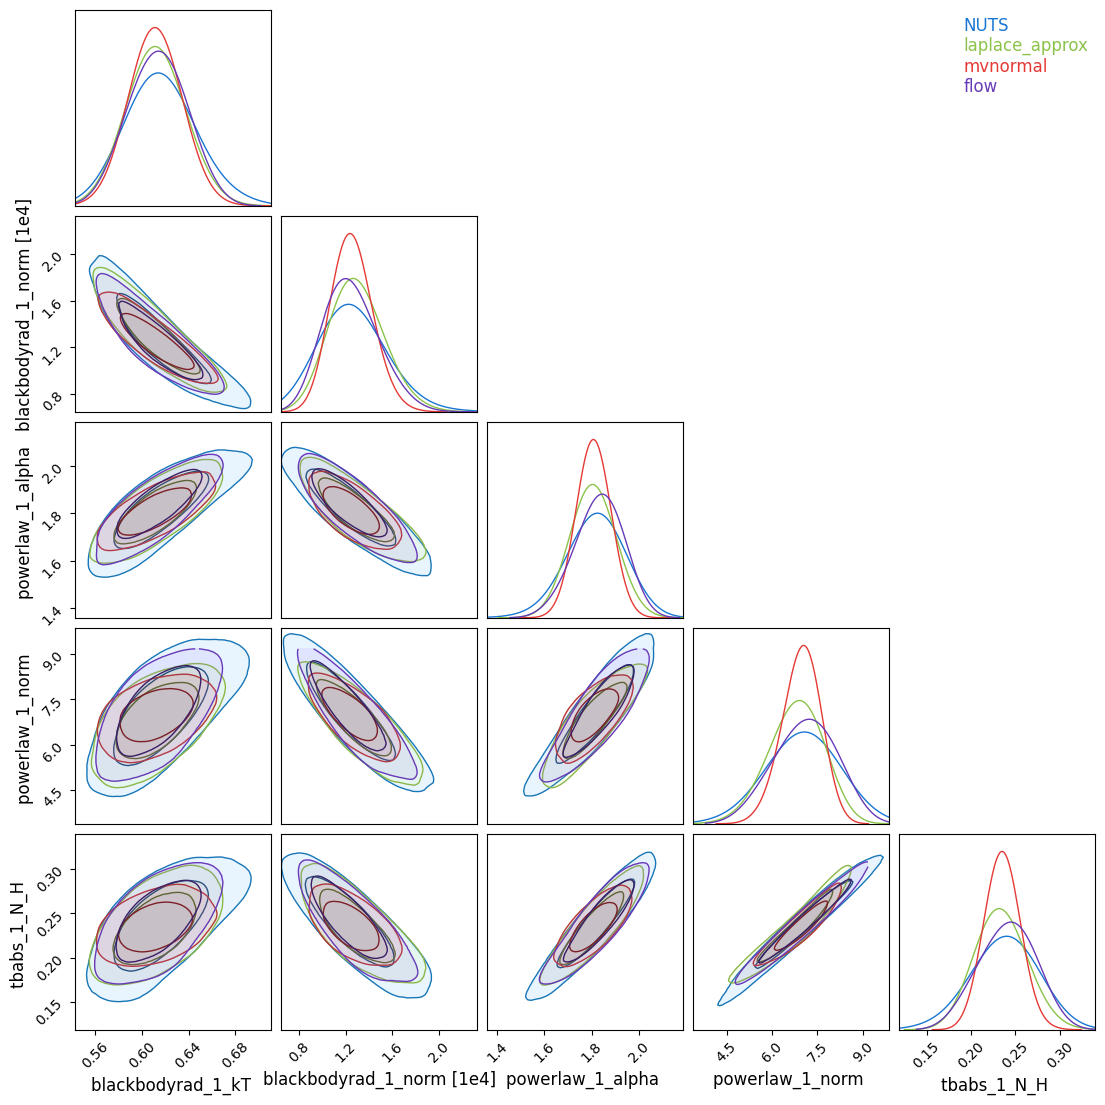

In [12]:
from chainconsumer import ChainConsumer

c = ChainConsumer()

for key, samples in results.items():

    c.add_chain(samples, name=key)

c.configure(kde=2., shade_alpha=0.1)
fig = c.plotter.plot(figsize=(12,12))